<a href="https://colab.research.google.com/github/joaochenriques/IST_MCTE/blob/main/Tides/LisbonTide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import numpy as np
import pandas as pd
from scipy import interpolate
import os, pathlib

if not pathlib.Path("mpl_utils.py").exists():
  os.system( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )
import mpl_utils as mut

mut.config_plots()
%config InlineBackend.figure_formats = ['svg']


In [2]:
if not pathlib.Path("Mares_2020_Hourly.xlsx").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/IST_MCTE/main/Tides/Mares_2020_Hourly.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66249  100 66249    0     0   257k      0 --:--:-- --:--:-- --:--:--  257k


In [3]:
!pip install git+https://github.com/moflaher/ttide_py

  Cloning https://github.com/moflaher/ttide_py to /tmp/pip-req-build-679ko7qp
  Running command git clone --filter=blob:none --quiet https://github.com/moflaher/ttide_py /tmp/pip-req-build-679ko7qp
  Resolved https://github.com/moflaher/ttide_py to commit 60aa10ec4d0fb6b51640c3886ced41e86b46aefa
  Preparing metadata (setup.py) ... done
  Created wheel for ttide: filename=ttide-0.3.dev1-py3-none-any.whl size=34184 sha256=4d73375a1e6533e735a12a5de5c58d2ead9a2c0cb86cfdfec75bf4dd5dbcca85
  Stored in directory: /tmp/pip-ephem-wheel-cache-1nx10i6x/wheels/77/e2/1d/d3a4dcbc6d746914fada49b8be99b7456ba2c76bd70c4dcde9
Successfully built ttide


In [ ]:
from ttide.t_tide import t_tide

In [4]:
MonthsName = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
              'September', 'October', 'November', 'December']
MonthsDays = np.array( [ 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31 ] )
TotalHours = MonthsDays.sum()*24.0

Tide data retrieved from
https://webpages.ciencias.ulisboa.pt/~cmantunes/hidrografia/hidro_mares.html

In [5]:
df=pd.read_excel('Mares_2020_Hourly.xlsx', "January" )

In [6]:
Annual_Time = []
Annual_Height = []

ElapsedDays  = 0

for Nm, Name in enumerate( MonthsName ):
    df = pd.read_excel('Mares_2020_Hourly.xlsx', Name )

    for Nd in range( MonthsDays[Nm] ):
        # print( Nm+1, Name, Nd+1 )
        Height = df[ Nd+1 ]
        for Nh in range( 24 ):
            h = Height[Nh]
            t = ElapsedDays * 24.0 + Nh
            Annual_Time.append( t )
            Annual_Height.append( h )

        ElapsedDays += 1

Annual_Time = np.array( Annual_Time )

Annual_Height = np.array( Annual_Height )
# remove the mean surface water level
Annual_Height -= np.mean( Annual_Height )

(1200.0, 1320.0)

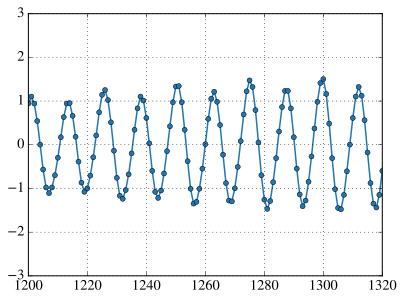

In [78]:
# piecewise linear plot of the tide
mpl.plot(Annual_Time,Annual_Height,'o-')
mpl.grid(which='both')
mpl.xlim( 1200, 1200+24*5 )

(0.0001454441043328608, 1.246710378497756)

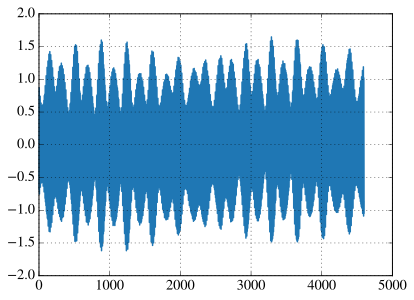

In [8]:
# define a dimensionless tide
mean_Amp = np.sqrt(2.0) * Annual_Height.std()
omega_ref = 2.0*np.pi / (12.00*3600.0)
Annual_Height_Star = Annual_Height / mean_Amp
Annual_Time_Star = (Annual_Time*3600.0) * omega_ref # convert Annual_Time to seconds
mpl.plot(Annual_Time_Star,Annual_Height_Star)
mpl.grid(which='both')
omega_ref, mean_Amp

# Use T_Tide to compute tide components

In [37]:
t_data = t_tide(Annual_Height, dt=1, lat=38.736946, out_style=None )

In [76]:
periods = []
print( f'comp   Per [H]  Amp [m]  Phi [°]' )
for comp, freq, fdata in zip( t_data['nameu'], t_data['fu'], t_data['tidecon'] ):
  comp = comp.decode('ascii')
  amp = fdata[0]
  phase = fdata[2]
  period = 1.0 / freq
  if amp > 0.01:
    periods.append( period )
    print( f'{comp}  {period:8.2f}  {amp:7.3f} {phase:8.2f}' )

comp   Per [H]  Amp [m]  Phi [°]
SA     8766.23    0.070   109.52
Q1       26.87    0.018    68.97
O1       25.82    0.063    67.79
P1       24.07    0.024   256.03
K1       23.93    0.070   253.19
2N2      12.91    0.028    62.17
MU2      12.87    0.026   285.48
N2       12.66    0.238    45.02
NU2      12.63    0.045   243.48
M2       12.42    1.146    22.68
LDA2     12.22    0.017   312.05
L2       12.19    0.029   157.76
T2       12.02    0.021   320.58
S2       12.00    0.392   139.48
K2       11.97    0.112   311.39
MN4       6.27    0.021   149.79
M4        6.21    0.057   129.94
MS4       6.10    0.031   261.89
M6        4.14    0.017   110.92


# Comparison of T_Tide results with an FFT

(1, 10000)

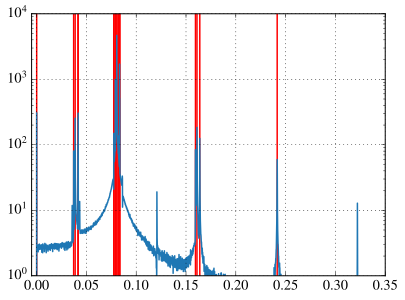

In [77]:
W = np.fft.fftfreq(Annual_Height.size, d=Annual_Time[1]-Annual_Time[0])

fsample = 1.0
delta_f = fsample / Annual_Height.size
Freqs = delta_f * np.array( range( Annual_Height.size ) )
f_hat = np.fft.fft(Annual_Height)

for T in periods:
    mpl.gca().axvline( 1.0/T, color='r' )

#%matplotlib qt
mpl.grid()
mpl.semilogy( Freqs, np.abs( f_hat ),lw=1.5 )
mpl.xlim( -0.005, 0.35 )
# mpl.xlim( 0.07, 0.09 )
mpl.ylim(1,10000)

# Tide spline interpolation

(1200.0, 1320.0)

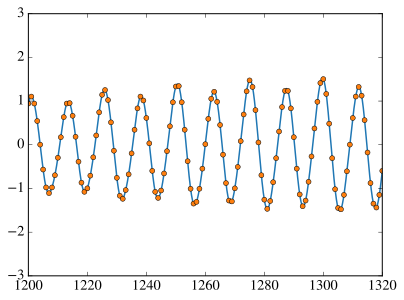

In [79]:
CS = interpolate.CubicSpline( Annual_Time, Annual_Height, bc_type='clamped' )
tnew = np.linspace(0, Annual_Time[-1], Annual_Height.size*60 )
out = CS(tnew)
mpl.plot( tnew, out )
mpl.plot(Annual_Time,Annual_Height,'o')
mpl.xlim( 1200, 1200+24*5 )